# Setup

In [1]:
import warnings
warnings.filterwarnings("ignore")

try:
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = False

if IN_COLAB:
    !git clone -qq https://github.com/kbayazitov/StockPricingForecasting.git /tmp/repo
    !python3 -m pip install -qq /tmp/repo/src/ && rm -rf /tmp/repo

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.6/17.6 MB 22.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 221.4/221.4 kB 11.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.6/294.6 kB 6.9 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-metadata 1.15.0 requires protobuf<4.21,>=3.20.3; python_version < "3.11", but you have protobuf 4.25.3 which is incompatible.


In [2]:
from mylib import (candles,
                   generate_dataset,
                   lstm,
                   transformer,
                   train,
                   plotting)

In [3]:
import numpy as np
import torch
import pandas as pd
import random
from tqdm.notebook import tqdm
import csv
import pylab
import scipy.stats as st
from datetime import datetime, timezone, timedelta
import itertools

import matplotlib.pyplot as plt
import seaborn as sns
from pylab import rcParams

rcParams['figure.figsize'] = (15, 6)
rcParams['legend.fontsize'] = 20
rcParams['axes.titlesize']=20
rcParams['axes.labelsize']=20
rcParams['font.size'] = 20
rcParams['lines.linewidth'] = 3
rcParams['axes.formatter.use_locale'] = True
sns.set(style="darkgrid", font_scale=1.4)

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [5]:
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Candles data

In [6]:
from config import TOKEN

data = candles.get_candles_data(
    ticker='YNDX',
    tf='1DAY',
    date_from=datetime(2022, 4, 27, tzinfo=timezone(offset=timedelta())),
    date_to=datetime(2024, 4, 27, tzinfo=timezone(offset=timedelta())),
    TOKEN=TOKEN
)

data['time'] = data['time'].apply(lambda x: x.date())

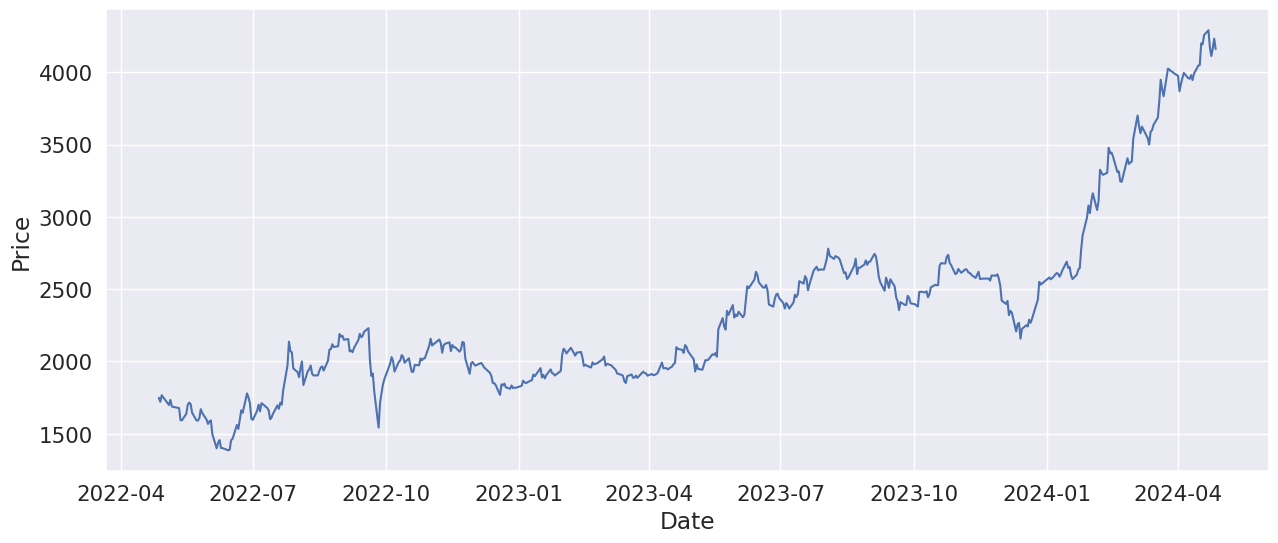

In [7]:
plt.plot(data['time'], data['close'])
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

# Autotracking

In [8]:
# No autotracking
data['value_base'] = 0

In [9]:
# Noise autotracking
mu, sigma = 0, 1
s = np.random.normal(mu, sigma, 1600)
b = 0
a = 1
scaled_s = (s - np.min(s)) * (b - a) / (np.max(s) - np.min(s)) + a

autotracking_df = pd.DataFrame({
    'value_noise':scaled_s,
    'time':pd.date_range('2020-01-01', periods=len(scaled_s))}
)
autotracking_df['time'] = autotracking_df['time'].apply(lambda x: x.date())

data = data.join(autotracking_df.set_index('time'), on='time')

In [10]:
# True autotracking
autotracking_df = pd.read_csv('https://raw.githubusercontent.com/kbayazitov/StockPricingForecasting/master/data/tracking.csv', sep=';', skiprows=[0,], names=['time', 'value_auto'])

autotracking_df['value_auto'] = autotracking_df['value_auto'].apply(lambda x: float(x.replace(',', '.')))

autotracking_df['time'] = pd.to_datetime(autotracking_df['time'])
autotracking_df = autotracking_df.sort_values(by='time')
autotracking_df = autotracking_df.reset_index(drop=True)
autotracking_df['time'] = autotracking_df['time'].apply(lambda x: x.date())

data = data.join(autotracking_df.set_index('time'), on='time')
data['value_auto'].fillna(0, inplace=True)

data.head()

,open,high,low,close,volume,time,value_base,value_noise,value_auto
0,1620.0,1770.0,1587.0,1748.6,915372,2022-04-27,0,0.196988,-0.1013
1,1767.0,1928.6,1717.0,1721.0,1226293,2022-04-28,0,0.632996,0.0000
2,1735.0,1817.6,1734.2,1766.6,395085,2022-04-29,0,0.617949,0.0848
3,1792.2,1813.6,1684.2,1699.0,368599,2022-05-04,0,0.342857,0.0000
4,1719.0,1751.8,1703.0,1734.4,187668,2022-05-05,0,0.623552,0.0000


# Stationarity

In [11]:
from statsmodels.tsa.stattools import kpss
import statsmodels.api as sm

from statsmodels.tools.sm_exceptions import InterpolationWarning
warnings.simplefilter('ignore', InterpolationWarning)

In [12]:
shift1 = 5
shift2 = 1

for param in ['open', 'close', 'high', 'low']:
    data[f'{param}_diff_1'] = data[f'{param}'] - data[f'{param}'].shift(shift1)
    data[f'{param}_diff_2'] = data[f'{param}_diff_1'] - data[f'{param}_diff_1'].shift(shift2)

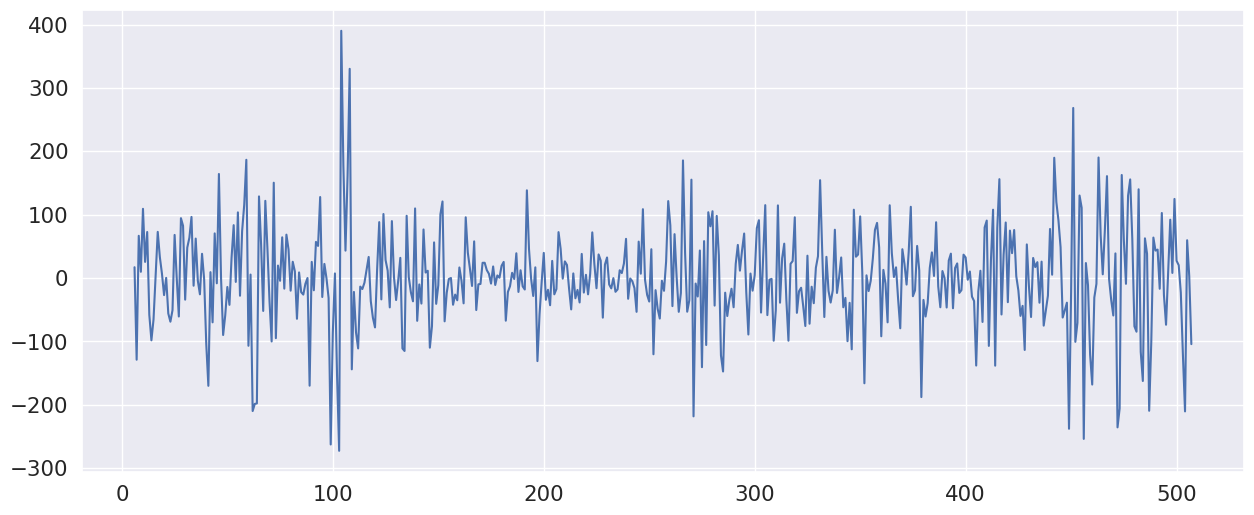

In [13]:
plt.plot(data['close_diff_2'][shift1+shift2:])

In [14]:
def kpss_test(series):
    statistic, p_value, _, _ = kpss(series)
    print(f'p-value: {p_value}')
    print(f'Result: The series is {"not " if p_value < 0.05 else ""}stationary')

kpss_test(data['close_diff_2'][shift1+shift2:])

p-value: 0.1
Result: The series is stationary


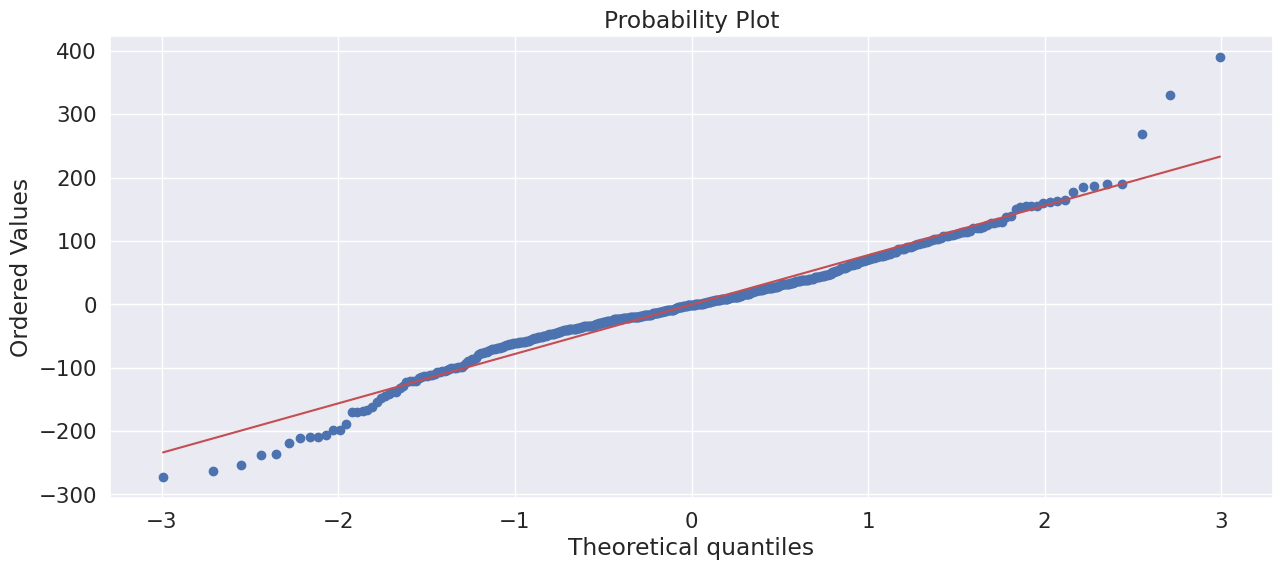

In [15]:
st.probplot(data['close_diff_2'][shift1+shift2:], dist="norm", plot=pylab)
pylab.show()

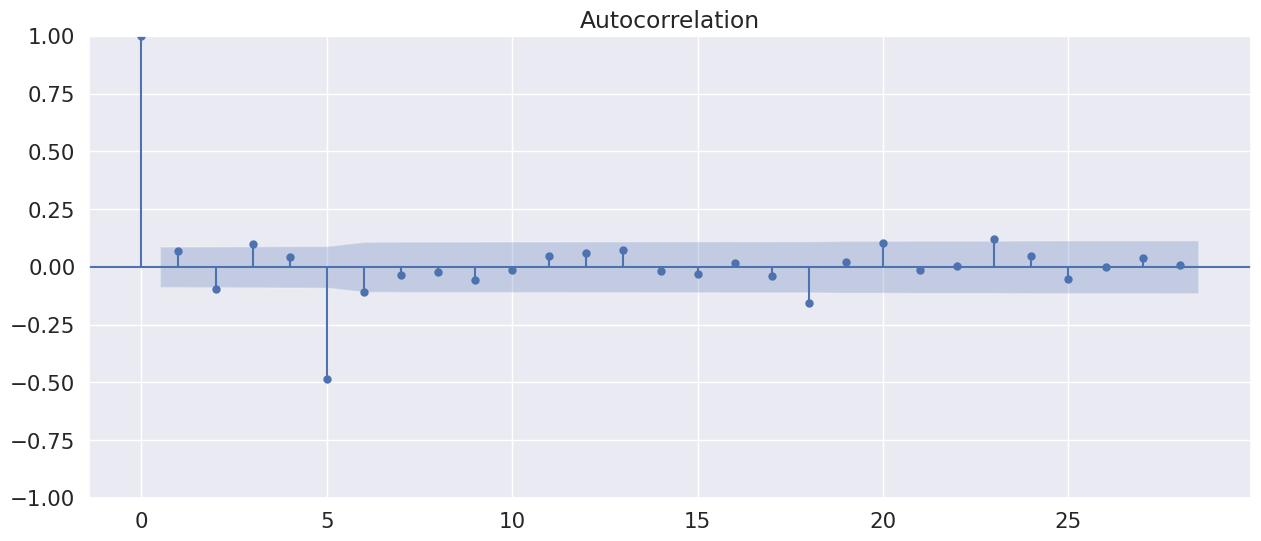

In [16]:
sm.graphics.tsa.plot_acf(data['close_diff_2'][shift1+shift2:])
plt.show()

# ARIMA

In [17]:
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error

from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)

In [18]:
def minmaxscaling(y, a=0, b=1):
    return (y - np.min(y)) * (b - a) / (np.max(y) - np.min(y)) + a

y = np.array(data['close_diff_2'][shift1+shift2:])
y = minmaxscaling(y)

split_ind = int(len(y) * 0.75)
y_train = y[:split_ind]
y_test = y[split_ind:]

In [19]:
p = q = range(0, 4)
d = [0] * 4
pdq = list(itertools.product(p, d, q))

In [ ]:
l_param = []
l_results_aic = []

for param in tqdm(pdq):
    try:
        mod = sm.tsa.statespace.SARIMAX(
            y_train,
            order=param,
            seasonal_order=(0,0,0,0),
            enforce_stationarity=False,
            enforce_invertibility=False
        )

        results = mod.fit()

        l_param.append(param)
        l_results_aic.append(results.aic)
    except:
        continue

In [ ]:
minimum=l_results_aic[0]
for ind in l_results_aic[1:]:
    if ind < minimum:
        minimum = ind
ind=l_results_aic.index(minimum)

print(l_param[ind])

(3, 0, 3)


In [20]:
model = sm.tsa.statespace.SARIMAX(
    y_train,
    #order=l_param[ind],
    order=(3,0,3),
    seasonal_order=(0, 0, 0, 0),
    enforce_stationarity=False,
    enforce_invertibility=False
)

fitted_model = model.fit()

print(fitted_model.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2199      0.047     -4.687      0.000      -0.312      -0.128
ar.L2          0.7077      0.024     29.030      0.000       0.660       0.755
ar.L3          0.5121      0.042     12.335      0.000       0.431       0.593
ma.L1          0.6418      0.703      0.912      0.362      -0.737       2.020
ma.L2         -0.6297      1.155     -0.545      0.586      -2.894       1.635
ma.L3         -1.0109      0.714     -1.416      0.157      -2.410       0.389
sigma2         0.0093      0.007      1.380      0.168      -0.004       0.023


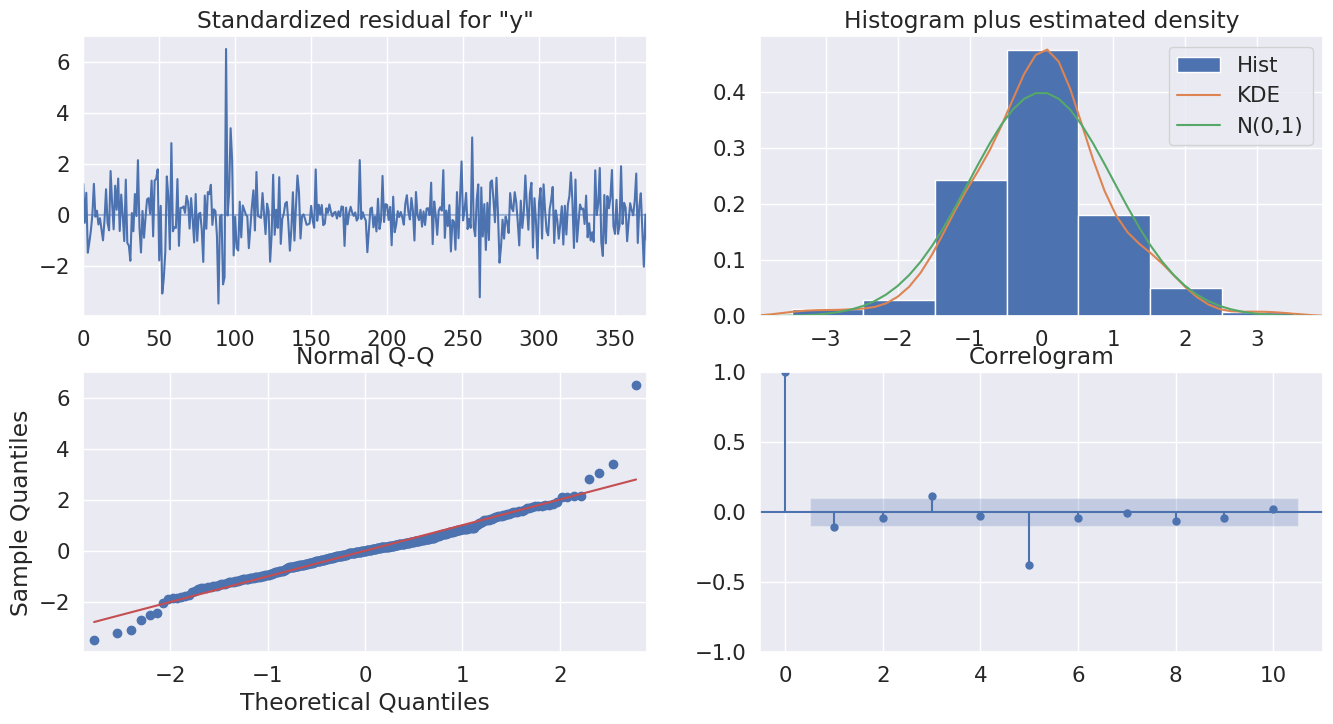

In [21]:
fitted_model.plot_diagnostics(figsize=(16, 8))
plt.show()

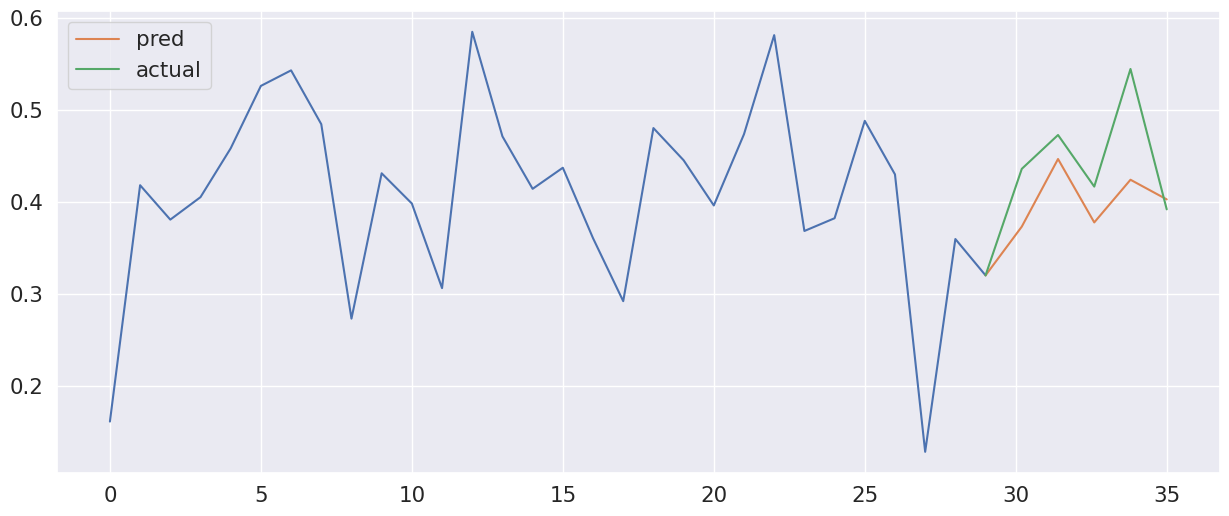

Corr = 0.34
MSE = 0.0183


In [ ]:
n_steps = 5

actual_values = []
predicted_values = []

step_actual = [[] for _ in range(n_steps)]
step_predicted = [[] for _ in range(n_steps)]

for i in range(len(y_test) - n_steps):
    append_model = fitted_model.append(list(y_test[:i+1]), refit=False)

    actual = y_test[i+1: i+1+n_steps]
    predicted = append_model.forecast(steps=n_steps)

    actual_values.extend(list(actual))
    predicted_values.extend(list(predicted))

    for step in range(n_steps):
        step_actual[step].append(actual[step])
        step_predicted[step].append(predicted[step])

    if i == 0:
        plt.plot(y_train[-30:])
        plt.plot(np.linspace(29, 29+n_steps+1, n_steps+1), [y_train[-1]] + list(predicted), label='pred')
        plt.plot(np.linspace(29, 29+n_steps+1, n_steps+1), [y_train[-1]] + list(actual), label='actual')
        plt.legend()
        plt.show()

# Calculate the Pearson correlation coefficient for each step
corrs = []
for step in range(n_steps):
    actual_values = np.array(step_actual[step])
    predicted_values = np.array(step_predicted[step])
    corr = np.corrcoef(actual_values, predicted_values)[0, 1]
    corrs.append(corr)

print(f'Corr = {round(np.array(corrs).mean(), 3)}')
print(f'MSE = {round(mean_squared_error(np.array(actual_values), np.array(predicted_values)), 4)}')

# LSTM - YNDX-Train15

In [ ]:
nf = 5
iw = 15
ow = 5

train_datasets, test_datasets = generate_dataset.get_datasets(data, iw=iw, ow=ow)

In [ ]:
input_size = nf
target_len = ow
hidden_size = 512
dropout = 0
num_layers = 1

epochs = 70
attempts = 3

corrs = []
losses = []
labels = ['base', 'noise',  'auto']
models = []

for i in range(len(train_datasets)):

    model = lstm.Seq2SeqLSTM(
        input_size=input_size,
        hidden_size=hidden_size,
        num_layers=num_layers,
        dropout=dropout,
        target_len=target_len
    )
    model.to(device)
    model.apply(lstm.init_weights)

    corr, loss, _, _ = train.train_model(
        model,
        train_datasets[i],
        test_datasets[i],
        n_steps=ow,
        attempts=attempts,
        epochs=epochs
    )

    corrs.append(corr)
    losses.append(loss)
    models.append(model)

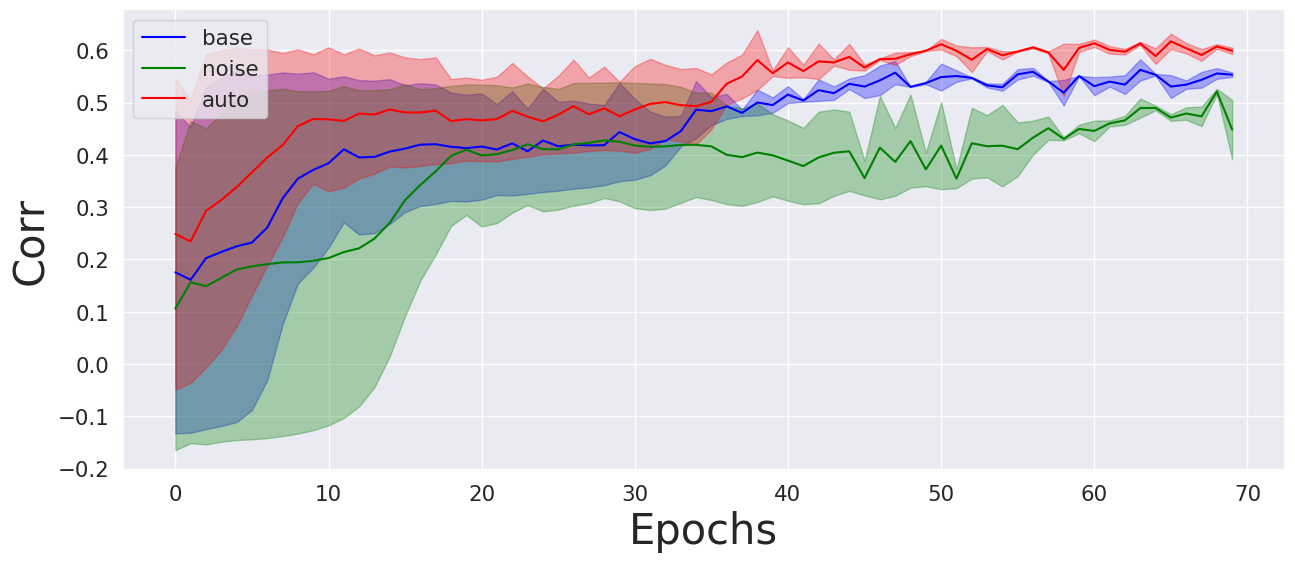

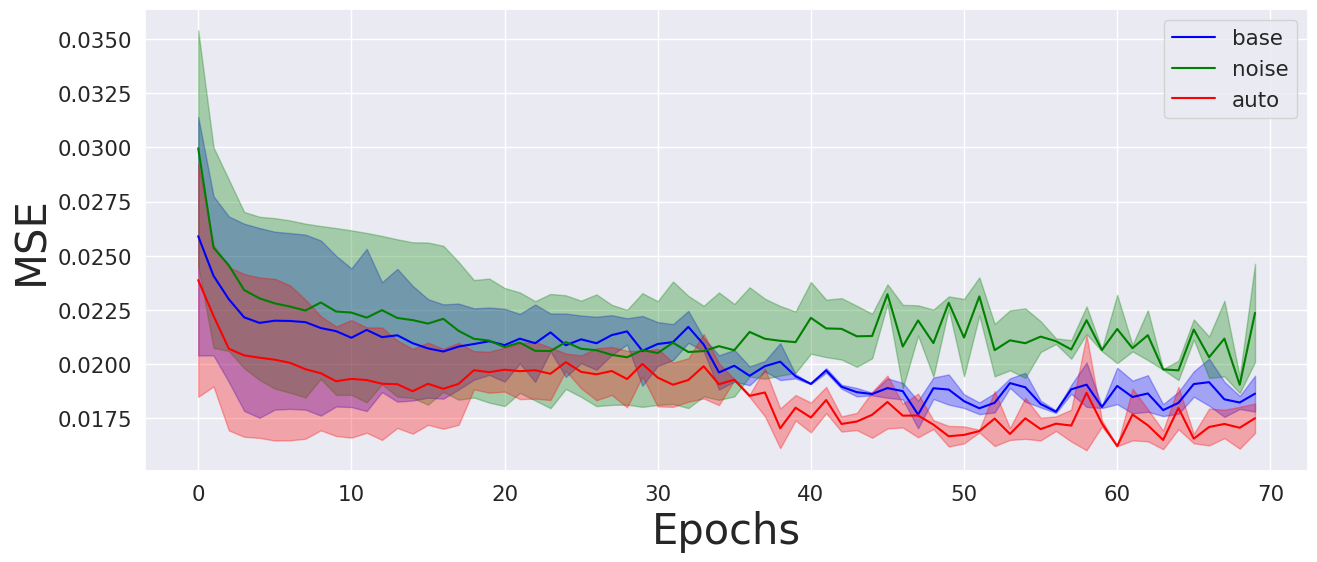

In [ ]:
plotting.makeplots(
    losses=losses,
    corrs=corrs,
    labels=labels,
    from_n=0
)

In [ ]:
for corr, loss, label in zip(corrs, losses, labels):
    print(label, 'corr = {} +- {}'.format(round(np.array(corr).mean(0)[-1], 3),
                                          round(np.array(corr).std(0)[-1], 3)))
    print(label, 'mse = {} +- {}'.format(round(np.array(loss).mean(0)[-1], 4),
                                         round(np.array(loss).std(0)[-1], 4)))

base corr = 0.553 +- 0.004
base mse = 0.0186 +- 0.0008
noise corr = 0.448 +- 0.057
noise mse = 0.0224 +- 0.0023
auto corr = 0.599 +- 0.006
auto mse = 0.0175 +- 0.0007


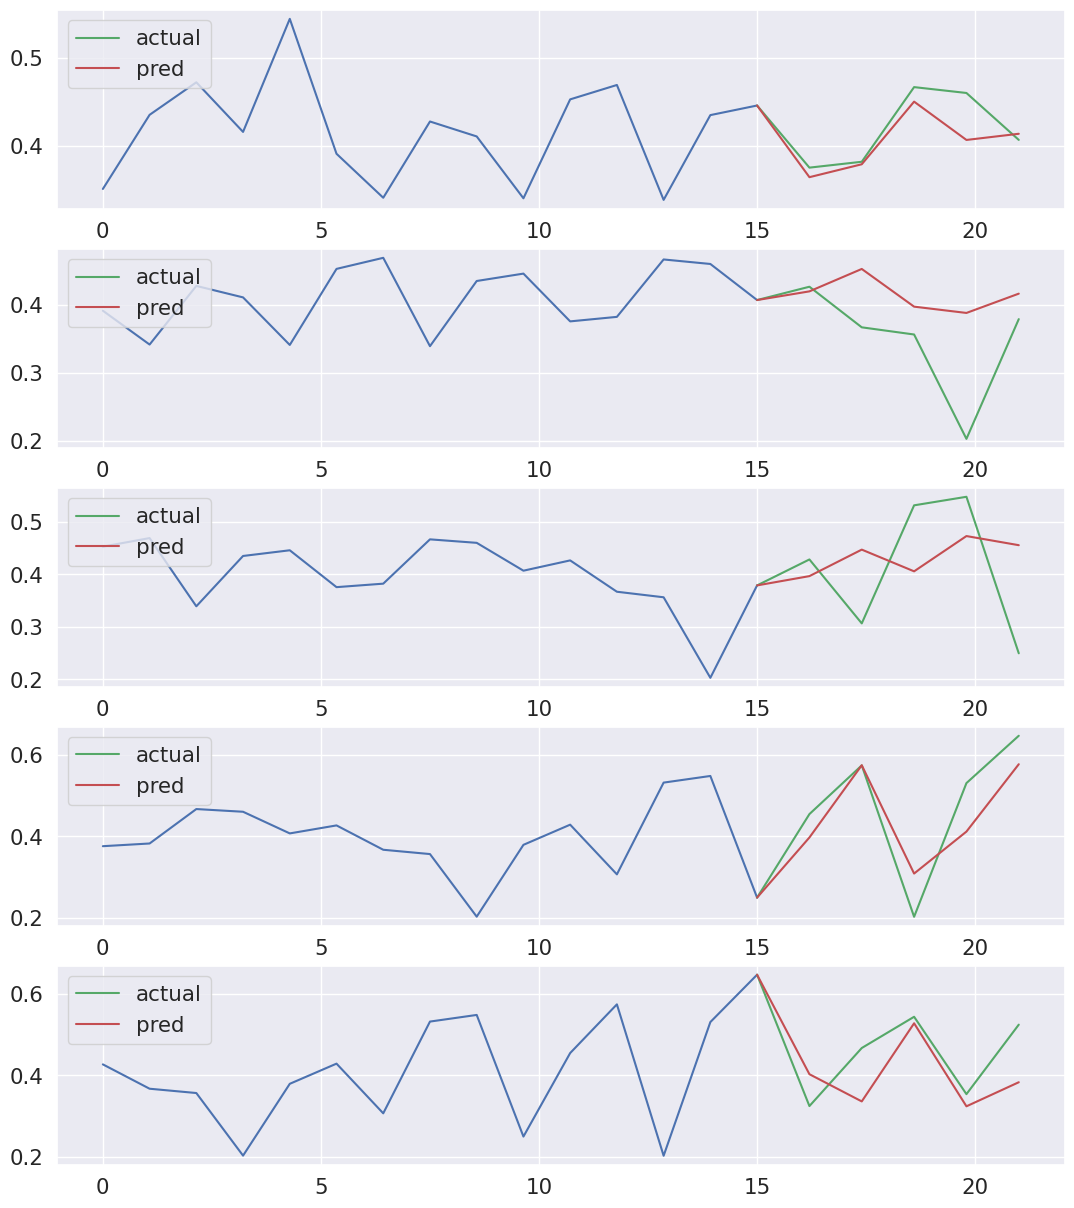

In [ ]:
plotting.plot_test_results(models[0], test_datasets[0], input_size=iw, output_size=ow)

# LSTM - YNDX-Train5

In [17]:
nf = 5
iw = 5
ow = 5

train_datasets, test_datasets = generate_dataset.get_datasets(data, iw=iw, ow=ow)

In [ ]:
input_size = nf
target_len = ow
hidden_size = 512
attempts = 2
epochs = 70
dropout = 0
num_layers = 1

corrs = []
losses = []
labels = ['base', 'noise',  'auto']
models = []

for i in range(len(train_datasets)):

    model = lstm.Seq2SeqLSTM(
        input_size=input_size,
        hidden_size=hidden_size,
        num_layers=num_layers,
        dropout=dropout,
        target_len=target_len
    )
    model.to(device)
    model.apply(lstm.init_weights)

    corr, loss, _, _ = train.train_model(
        model,
        train_datasets[i],
        test_datasets[i],
        n_steps=ow,
        attempts=attempts,
        epochs=epochs
    )

    corrs.append(corr)
    losses.append(loss)
    models.append(model)

In [25]:
for corr, loss, label in zip(corrs, losses, labels):
    print(label, 'corr = {} +- {}'.format(round(np.array(corr).mean(0)[-1], 3),
                                          round(np.array(corr).std(0)[-1], 3)))
    print(label, 'mse = {} +- {}'.format(round(np.array(loss).mean(0)[-1], 4),
                                         round(np.array(loss).std(0)[-1], 4)))

base corr = 0.476 +- 0.027
base mse = 0.0175 +- 0.0003
noise corr = 0.478 +- 0.003
noise mse = 0.0175 +- 0.0003
auto corr = 0.51 +- 0.036
auto mse = 0.0171 +- 0.0001


# LSTM - YNDX-Train30

In [ ]:
nf = 5
iw = 30
ow = 5

train_datasets, test_datasets = generate_dataset.get_datasets(data, iw=iw, ow=ow)

In [ ]:
input_size = nf
target_len = ow
hidden_size = 512
attempts = 3
epochs = 70
dropout = 0
num_layers = 1

corrs = []
losses = []
labels = ['base', 'noise',  'auto']
models = []

for i in range(len(train_datasets)):

    model = lstm.Seq2SeqLSTM(
        input_size=input_size,
        hidden_size=hidden_size,
        num_layers=num_layers,
        dropout=dropout,
        target_len=target_len
    )
    model.to(device)
    model.apply(lstm.init_weights)

    corr, loss, _, _ = train.train_model(
        model,
        train_datasets[i],
        test_datasets[i],
        n_steps=ow,
        attempts=attempts,
        epochs=epochs
    )

    corrs.append(corr)
    losses.append(loss)
    models.append(model)

In [ ]:
for corr, loss, label in zip(corrs, losses, labels):
    print(label, 'corr = {} +- {}'.format(round(np.array(corr).mean(0)[-1], 3),
                                          round(np.array(corr).std(0)[-1], 3)))
    print(label, 'mse = {} +- {}'.format(round(np.array(loss).mean(0)[-1], 4),
                                         round(np.array(loss).std(0)[-1], 4)))

base corr = 0.478 +- 0.006
base mse = 0.0195 +- 0.0005
noise corr = 0.496 +- 0.029
noise mse = 0.0224 +- 0.0042
auto corr = 0.538 +- 0.07
auto mse = 0.0186 +- 0.0017


# LSTM horizon change

In [ ]:
nf = 5
iw = 15

datasets_train_pt_base = []
datasets_test_pt_base = []

n = [5, 7, 9]

for ow in n:
    ((dataset_train_pt_base, _, _),
        (dataset_test_pt_base, _, _)) = generate_dataset.get_datasets(data, iw=iw, ow=ow)

    datasets_train_pt_base.append(dataset_train_pt_base)
    datasets_test_pt_base.append(dataset_test_pt_base)

In [ ]:
input_size = nf
target_len = ow
hidden_size = 512
dropout = 0
num_layers = 1

epochs = 80
attempts = 1

corrs = []
losses = []
labels = [f'horizon={x}' for x in n]

for i in range(len(datasets_train_pt_base)):

    model = lstm.Seq2SeqLSTM(
        input_size=input_size,
        hidden_size=hidden_size,
        num_layers=num_layers,
        dropout=dropout,
        target_len=n[i]
    )
    model.to(device)
    model.apply(lstm.init_weights)

    corr, loss, _, _ = train.train_model(
        model,
        datasets_train_pt_base[i],
        datasets_test_pt_base[i],
        n_steps=n[i],
        attempts=attempts,
        epochs=epochs
    )

    corrs.append(corr)
    losses.append(loss)

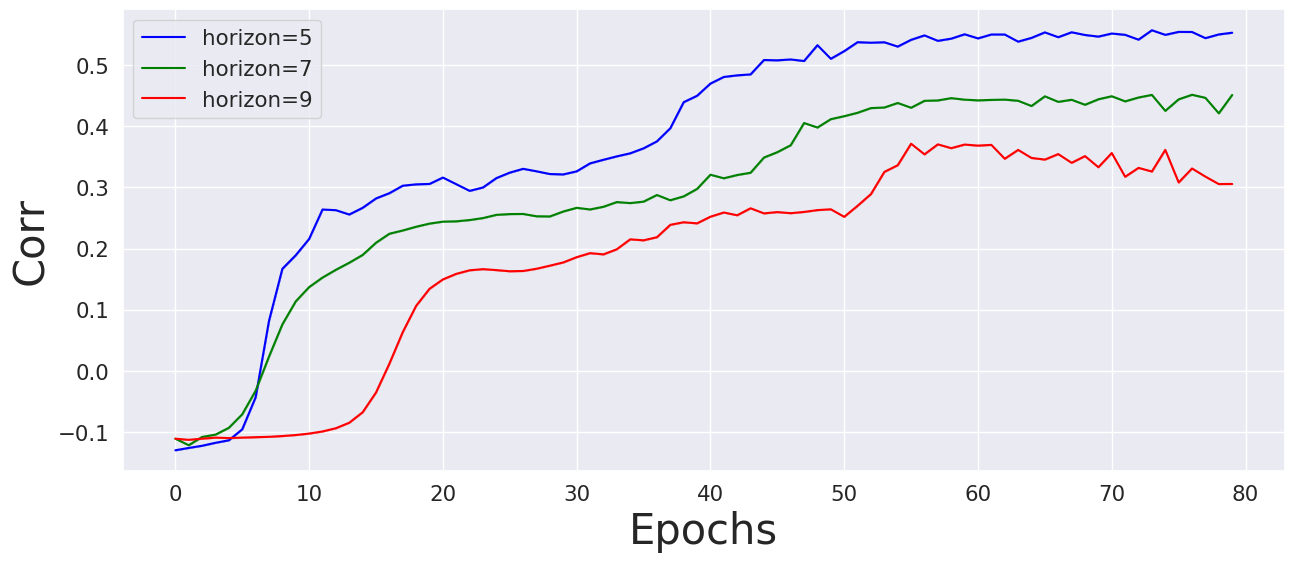

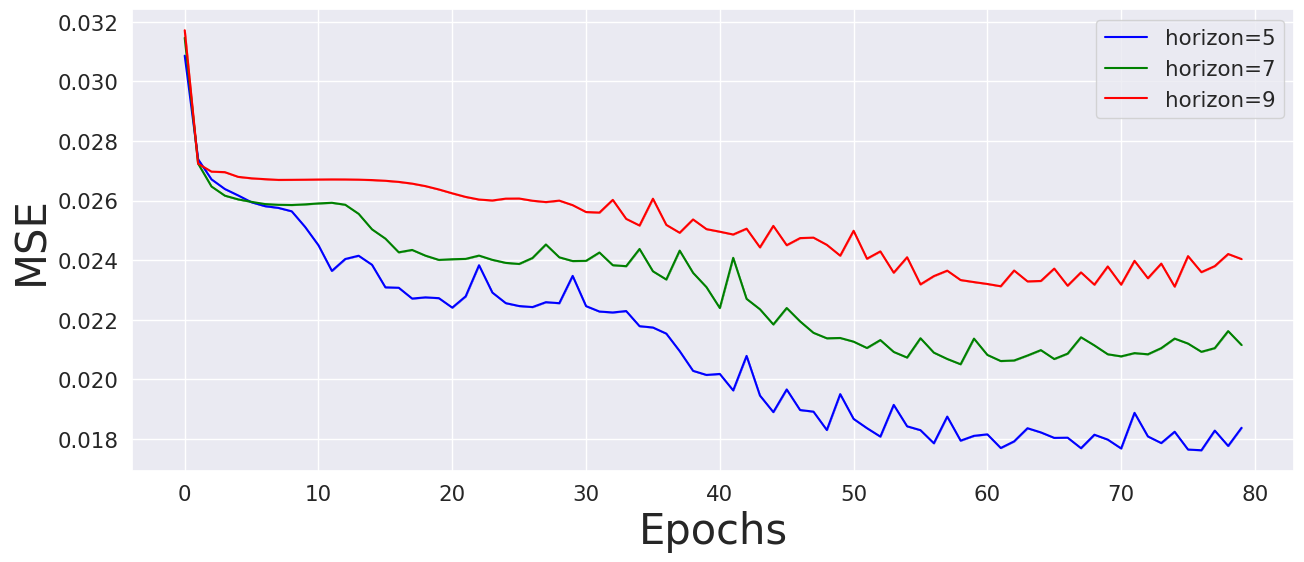

In [ ]:
plotting.makeplots(
    losses=losses,
    corrs=corrs,
    labels=labels,
    from_n=0
)

# Transformer - YNDX-Train15

In [17]:
nf = 5
iw = 15
ow = 5

train_datasets, test_datasets = generate_dataset.get_datasets(data, iw=iw, ow=ow)
train_datasets = [train_datasets[i] for i in [0, 2]]
test_datasets = [test_datasets[i] for i in [0, 2]]

In [ ]:
input_size = nf
target_len = ow
emb_size = 16
hidden_dim = 64
num_layers = 1
nhead = 8

epochs = 500
attempts = 3

corrs = []
losses = []
labels = ['base', 'auto']
models = []

for i in range(len(train_datasets)):

    model = transformer.Seq2SeqTransformer(
        feature_size=input_size,
        emb_size=emb_size,
        hidden_dim=hidden_dim,
        num_layers=num_layers,
        nhead=nhead,
        trg_len=target_len
    )
    model.to(device)

    corr, loss, _, _ = train.train_model(
        model,
        train_datasets[i],
        test_datasets[i],
        n_steps=ow,
        attempts=attempts,
        epochs=epochs
    )

    corrs.append(corr)
    losses.append(loss)
    models.append(model)

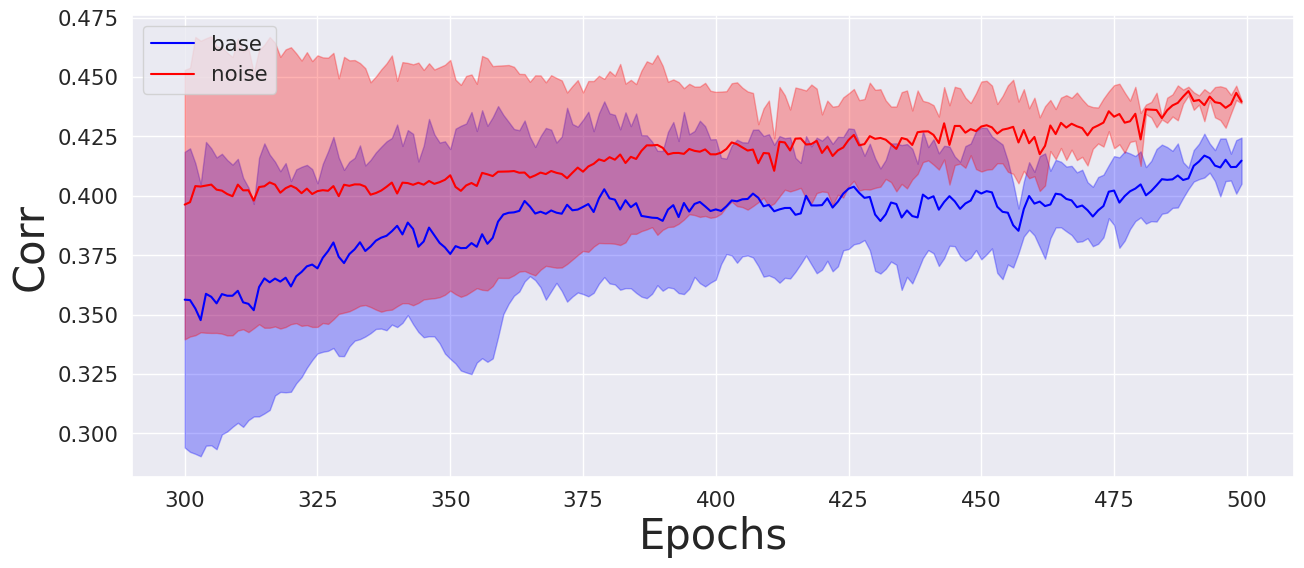

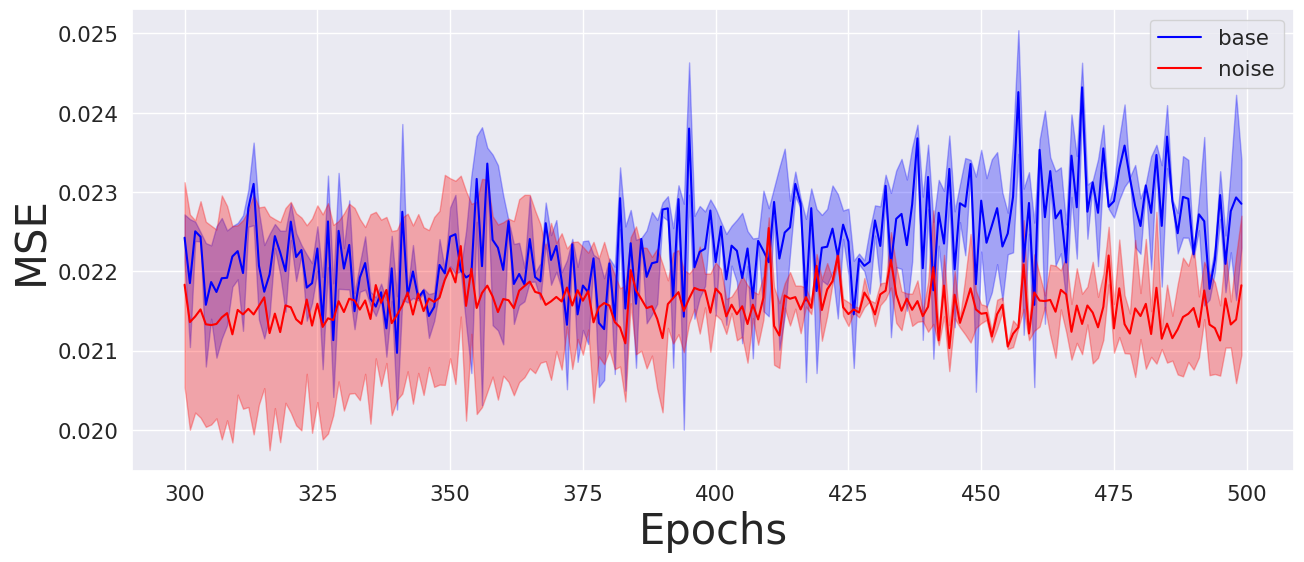

In [62]:
plotting.makeplots(
    losses=losses,
    corrs=corrs,
    labels=labels,
    colors=['blue', 'red'],
    from_n=300
)

In [67]:
for corr, loss, label in zip(corrs, losses, labels):
    print(label, 'corr = {} +- {}'.format(round(np.array(corr).mean(0)[-1], 3),
                                          round(np.array(corr).std(0)[-1], 3)))
    print(label, 'mse = {} +- {}'.format(round(np.array(loss).mean(0)[-1], 4),
                                         round(np.array(loss).std(0)[-1], 4)))

base corr = 0.415 +- 0.01
base mse = 0.0229 +- 0.0006
auto corr = 0.44 +- 0.001
auto mse = 0.0218 +- 0.0009


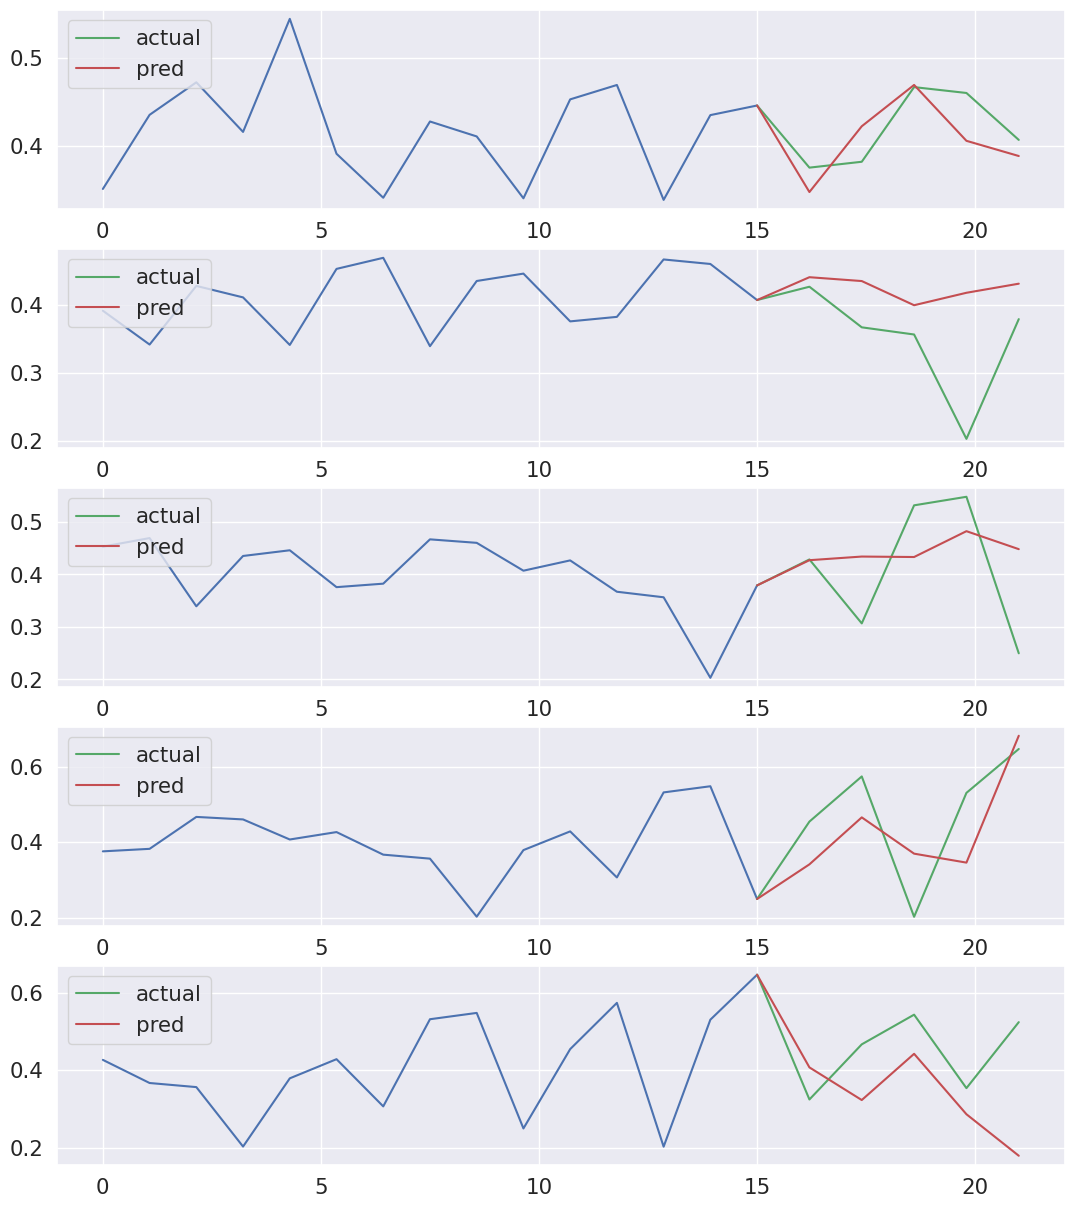

In [25]:
plotting.plot_test_results(models[0], test_datasets[0], input_size=iw, output_size=ow)